<a href="https://colab.research.google.com/github/KlebersonMariaCC/ia_2021.1/blob/main/Projeto_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib imageio pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.1 MB/s 


Aqui importamos as bibliotecas necessárias para o funcionamento do nosso algoritmo. Elas nos permitem desde plot de gráficos até estruturas de dados que simplificam nossa solução.

In [ ]:
import numpy as np
from queue import PriorityQueue, Queue
import time
import sys, getopt
import pygad
import matplotlib.pyplot
import imageio
import operator
import functools


<h2>Estados </h2>
<p> ■ Uma descrição de estado especifica a posição de
cada uma das 15 peças e do espaço vazio em um
dos 16 quadrados.
</p>
<h3> Estado inicial </h3>

<p>■ Qualquer estado pode ser designado como estado
inicial.
No nosso código, podemos editar o estado inicial arbitrariamente.
</p>

<h3>Função Sucessor  </h3>

<p>■ Gera os estados válidos que resultam da tentativa de
executar as três ações (o espaço vazio se desloca
para a Esquerda, Direita, Acima ou Abaixo).
<p>

<h3>Teste de objetivo </h3>

<p>■ Verifica se o estado corresponde à
configuração de objetivo mostrada na figura
No nosso código, podemos editar o estado objetivo de modo arbitrário.
<p>
<h3> Custo de caminho</h3>
<p>■ Cada passo custa 1, e assim o custo do
caminho é o número de passos do caminho e o tempo de resolução do problema. </p>



<h1> Instância do jogo</h1>
<p> Essa é a classe que define uma instância do jogo. Ela contem as heuristicas, a saber: distância de manhattan, blocos fora do lugar e distância euclidiana. Com base nelas é calculado um fitness interno para cada estado, que serve na escolha do estado como possivel sucessor </p>

In [ ]:
class GameState():
    def __init__(self, state, goal_state, level, parent = None, heuristic_func = None):
        self.__state = state
        self.__goal_state = goal_state
        self.__level = level
        self.__heuristic_func = heuristic_func
        self.__heuristic_score = level
        self.__parent = parent
        self.calculate_fitness()

    def __hash__(self):
        return hash(str(self.__state))

    def __lt__(self, other):
        return self.__heuristic_score < other.__heuristic_score

    def __eq__(self, other):
        return self.__heuristic_score == other.__heuristic_score

    def __gt__(self, other):
        return self.__heuristic_score > other.__heuristic_score

    def get_state(self):
        return self.__state

    def get_score(self):
        return self.__heuristic_score

    def get_level(self):
        return self.__level

    def get_parent(self):
        return self.__parent

    def calculate_fitness(self):
        self.__heuristic_score += self.misplaced_tiles(self.__heuristic_func[0]) + self.manhattan(self.__heuristic_func[1]) + self.euclidean(self.__heuristic_func[2])

    def misplaced_tiles(self,w0):
        heuristic_score = 0
        for cur_tile, goal_tile in zip(self.__state, self.__goal_state):
                if cur_tile != goal_tile:
                    heuristic_score += 1
        return w0 * heuristic_score

    def manhattan(self,w1):
        heuristic_score = 0
        for cur_tile in self.__state:
                cur_idx = self.__state.index(cur_tile)
                goal_idx = self.__goal_state.index(cur_tile)
                cur_i, cur_j = cur_idx // int(np.sqrt(len(self.__state))), cur_idx % int(np.sqrt(len(self.__state)))
                goal_i, goal_j = goal_idx // int(np.sqrt(len(self.__state))), goal_idx % int(np.sqrt(len(self.__state)))
                heuristic_score += self.calculate_manhattan(cur_i, cur_j, goal_i, goal_j)

        return w1 * heuristic_score


    def calculate_manhattan(self, x1, y1, x2, y2):
        return abs(x1 - x2) + abs(y1 - y2)

    def euclidean(self,w3):
        heuristic_score = 0
        for cur_tile in self.__state:
                cur_idx = self.__state.index(cur_tile)
                goal_idx = self.__goal_state.index(cur_tile)
                cur_i, cur_j = cur_idx // int(np.sqrt(len(self.__state))), cur_idx % int(np.sqrt(len(self.__state)))
                goal_i, goal_j = goal_idx // int(np.sqrt(len(self.__state))), goal_idx % int(np.sqrt(len(self.__state)))
                heuristic_score += self.calculate_euclidean(cur_i, cur_j, goal_i, goal_j)

        return w3 * heuristic_score

    def calculate_euclidean(self, x1, y1, x2, y2):
        return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

<h1> Solucionando o Problema </h1>

<p> Essa é a classe que em última instância resolve o problema. A partir do fitness de cada estado, transiciona entre os estados da árvore de possibilidades indo em direção ao estado objetivo. Possui um método solve_a_star que retorna o caminho da solução, e um atributo get_summary que resume as metricas que serão usadas no eha* : nível da árvore, nós visitados e tempo gasto. Existe um atributo de número máximo de iterações, então é possivel que não se consiga resolver alguns estados iniciais. </p>

In [ ]:
class Solver():
    def __init__(self, init_state, goal_state, heuristic_func, max_iter = 25000):
        self.__init_state = init_state
        self.__goal_state = goal_state
        self.__heuristic_func = heuristic_func
        self.__MAX = 100000
        self.__max_iter = max_iter
        self.__path = []
        self.__number_of_steps = 0
        self.__summary = ""

    def set_max_iter(self, max_iter):
        self.__max_iter = max_iter

    def get_path(self):
        return self.__path

    def get_summary(self):
        return self.__summary

    def solve_a_star(self):
        x_axis = [1, 0, -1,  0]
        y_axis = [0, 1,  0, -1]

        level = 0
        visited_nodes = set()

        start_time = time.perf_counter()

        nodes = PriorityQueue(self.__MAX)
        init_node = GameState(self.__init_state.flatten().tolist(), self.__goal_state.flatten().tolist(), level, parent = None, heuristic_func = self.__heuristic_func)
        nodes.put(init_node)

        epochs = 0
        while nodes.qsize() and epochs <= self.__max_iter:
            epochs += 1

            cur_node = nodes.get()
            cur_state = cur_node.get_state()

            if str(cur_state) in visited_nodes:
                continue
            visited_nodes.add(str(cur_state))

            if cur_state == self.__goal_state.flatten().tolist():
                self.__summary = [cur_node.get_level(), epochs, np.round(time.perf_counter() - start_time, 4)]
                while cur_node.get_parent():
                    self.__path.append(cur_node)
                    cur_node = cur_node.get_parent()
                break

            empty_tile = cur_state.index(0)
            i, j = empty_tile // self.__goal_state.shape[0], empty_tile % self.__goal_state.shape[0]

            cur_state = np.array(cur_state).reshape(self.__goal_state.shape[0], self.__goal_state.shape[0])
            for x, y in zip(x_axis, y_axis):
                new_state = np.array(cur_state)
                if i + x >= 0 and i + x < self.__goal_state.shape[0] and j + y >= 0 and j + y < self.__goal_state.shape[0]:
                    new_state[i, j], new_state[i+x, j+y] = new_state[i+x, j+y], new_state[i, j]
                    game_state = GameState(new_state.flatten().tolist(), self.__goal_state.flatten().tolist(), cur_node.get_level() + 1, cur_node, self.__heuristic_func)
                    if str(game_state.get_state()) not in visited_nodes:
                        nodes.put(game_state)
        if epochs > self.__max_iter:
            print('This grid setting is not solvable')
        return self.__path

<h1> A* <h1>

<p> Essa é a função que exibe a transição de estados até o estado objetivo. A representação dos estados é de listas de listas (matriz). É também mostrado o movimento realizado (cima, baixo, direita, ou esquerda) e o valor do fitness de cada estado, além dos pesos usados nas heurísticas. Caso não haja uma solução, uma mensagem é exibida no terminal. </p>

In [ ]:
def A_star(init_state, goal_state, max_iter, heuristic):
    solver = Solver(init_state, goal_state, heuristic, max_iter)
    path = solver.solve_a_star()


    if len(path) == 0:
        exit(1)

    init_idx = init_state.flatten().tolist().index(0)
    init_i, init_j = init_idx // goal_state.shape[0], init_idx % goal_state.shape[0]

    print()
    print('INITIAL STATE')
    for i in range(goal_state.shape[0]):
        print(init_state[i, :])
    print()
    for node in reversed(path):
        cur_idx = node.get_state().index(0)
        cur_i, cur_j = cur_idx // goal_state.shape[0], cur_idx % goal_state.shape[0]

        new_i, new_j = cur_i - init_i, cur_j - init_j
        if new_j == 0 and new_i == -1:
            print('Moved UP    from ' + str((init_i, init_j)) + ' --> ' + str((cur_i, cur_j)))
        elif new_j == 0 and new_i == 1:
            print('Moved DOWN  from ' + str((init_i, init_j)) + ' --> ' + str((cur_i, cur_j)))
        elif new_i == 0 and new_j == 1:
            print('Moved RIGHT from ' + str((init_i, init_j)) + ' --> ' + str((cur_i, cur_j)))
        else:
            print('Moved LEFT  from ' + str((init_i, init_j)) + ' --> ' + str((cur_i, cur_j)))
        print('Score using w0 = ' + str(heuristic[0]) + " w1 = " + str(heuristic[1]) + " w2 = " + str(heuristic[2]) + ' heuristic is ' + str(node.get_score() - node.get_level()) + ' in level ' + str(node.get_level()))

        init_i, init_j = cur_i, cur_j

        for i in range(goal_state.shape[0]):
            print(np.array(node.get_state()).reshape(goal_state.shape[0], goal_state.shape[0])[i, :])
        print()
    print(solver.get_summary())

In [ ]:
max_iter = 100000
n = 4
w0 = 1.0
w1 = 4.0
w2 = 8.0
heuristic = [w0, w1, w2]
levels = list()
gens = list()

init_state = "2 15 5 4 10 0 8 13 14 3 9 7 1 6 12 11"
goal_state = "1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0"

In [ ]:
init_state = init_state.split()
for i in range(len(init_state)):
    init_state[i] = int(init_state[i])

goal_state = goal_state.split()
for i in range(len(goal_state)):
    goal_state[i] = int(goal_state[i])

init_state = np.array(init_state).reshape(n, n)
goal_state = np.array(goal_state).reshape(n, n)

In [ ]:
A_star(init_state, goal_state, max_iter, heuristic)


INITIAL STATE
[ 2 15  5  4]
[10  0  8 13]
[14  3  9  7]
[ 1  6 12 11]

Moved DOWN  from (1, 1) --> (2, 1)
Score using w0 = 1 w1 = 4 w2 = 8 heuristic is 388.80197011896416 in level 1
[ 2 15  5  4]
[10  3  8 13]
[14  0  9  7]
[ 1  6 12 11]

Moved RIGHT from (2, 1) --> (2, 2)
Score using w0 = 1 w1 = 4 w2 = 8 heuristic is 366.2271347979506 in level 2
[ 2 15  5  4]
[10  3  8 13]
[14  9  0  7]
[ 1  6 12 11]

Moved DOWN  from (2, 2) --> (3, 2)
Score using w0 = 1 w1 = 4 w2 = 8 heuristic is 351.5997177999811 in level 3
[ 2 15  5  4]
[10  3  8 13]
[14  9 12  7]
[ 1  6  0 11]

Moved RIGHT from (3, 2) --> (3, 3)
Score using w0 = 1 w1 = 4 w2 = 8 heuristic is 331.2860093009963 in level 4
[ 2 15  5  4]
[10  3  8 13]
[14  9 12  7]
[ 1  6 11  0]

Moved UP    from (3, 3) --> (2, 3)
Score using w0 = 1 w1 = 4 w2 = 8 heuristic is 354.86084462200984 in level 5
[ 2 15  5  4]
[10  3  8 13]
[14  9 12  0]
[ 1  6 11  7]

Moved LEFT  from (2, 3) --> (2, 2)
Score using w0 = 1 w1 = 4 w2 = 8 heuristic is 349.174553

<h1> Print da excução anterior <h1>


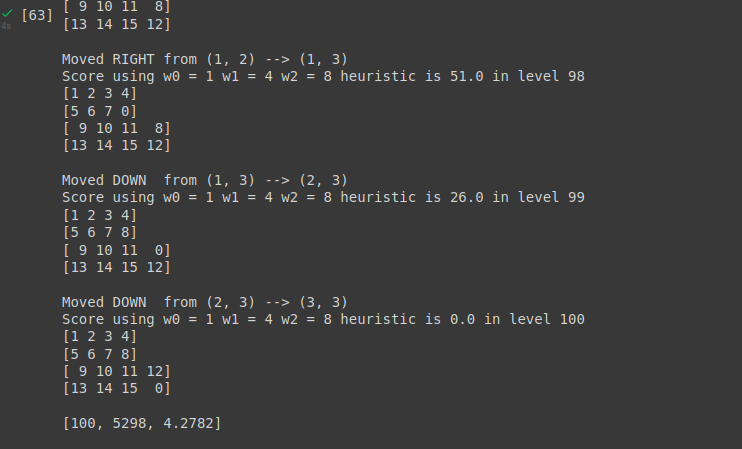

## EHA*

In [ ]:
def fitness_func(solution, solution_idx):
    a_star = Solver(np.array([[2,15,5,4],[10,0,8,13],[14,3,9,7],[1,6,12,11]]), np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,0]]),solution, 25000)
    a_star.solve_a_star()
    output = a_star.get_summary()
    print(a_star.get_summary())
    if output == "":
        fitness = 0
    else:
        fitness = 1/(output[0]) + 1/(output[1]) + 1/(output[2])
    return fitness

In [ ]:
def on_generation_func(ga_instance) :
  gen = ga_instance.generations_completed
  best_solution = ga_instance.best_solution()[0]
  a_star = Solver(np.array([[2,15,5,4],[10,0,8,13],[14,3,9,7],[1,6,12,11]]), np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,0]]),best_solution, 25000)
  a_star.solve_a_star()
  output = a_star.get_summary()
  if output == "":
        return
  else:
    gens.append(gen)
    levels.append(output[0])



/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:490: UserWarning: The percentage of genes to mutate (mutation_percent_genes=5) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes, mutation_num=mutation_num_genes))


This grid setting is not solvable

This grid setting is not solvable

This grid setting is not solvable

[62, 11125, 9.2594]
[80, 2104, 2.4]
[80, 3078, 3.0044]
[60, 4946, 4.0031]
This grid setting is not solvable

[80, 4879, 3.8502]
[72, 6229, 5.1099]
[80, 6597, 5.3138]
[96, 1729, 1.3342]
[90, 12073, 9.5063]
[54, 3383, 2.7699]
[80, 8277, 6.6728]
[80, 4879, 3.8342]
[72, 6229, 5.117]
[80, 6597, 5.5182]
[96, 1729, 1.3998]
[90, 12073, 10.7901]
[54, 3383, 2.7516]
[80, 8277, 6.6059]
[80, 1497, 1.2115]
[74, 7794, 6.1928]
[90, 8269, 6.546]
[80, 1720, 1.4567]
[80, 1677, 1.4347]
[74, 8152, 6.6867]
[80, 3313, 2.6535]
[80, 1497, 1.2447]
[74, 7794, 6.3385]
[90, 8269, 6.4719]
[80, 1720, 1.3494]
[80, 1677, 1.3623]
[74, 8152, 6.5276]
[80, 3313, 2.6067]
[96, 1740, 1.4071]
[80, 1624, 1.286]
[80, 1641, 1.2828]
[80, 1654, 1.3592]
[96, 1608, 1.2803]
[80, 1549, 1.2276]
[98, 2086, 1.6496]
[96, 1740, 1.4629]
[80, 1624, 1.6307]
[80, 1641, 2.2404]
[80, 1654, 1.2896]
[96, 1608, 1.2949]
[80, 1549, 1.2841]
[98, 20

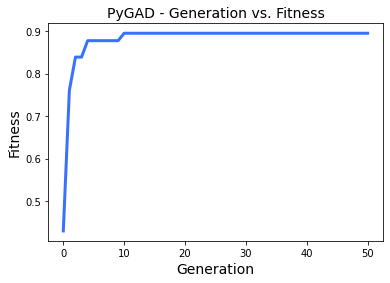

[80, 1676, 1.3731]
[80, 1578, 1.2836]
[80, 1943, 1.5334]
[80, 1946, 1.5745]
[80, 1547, 1.2272]
[80, 1713, 1.4387]
[80, 1547, 1.2395]
Parameters of the best solution : [2.89608884 2.46852481 3.95269117]
Fitness value of the best solution = 0.8947162729073871


In [ ]:
fitness_function = fitness_func
on_generation = on_generation_func

num_generations = 50
num_parents_mating = 4

sol_per_pop = 8
num_genes = 3
gene_type = [float,float,float]

init_range_low = -10
init_range_high = 10

parent_selection_type = "rank"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       on_generation = on_generation)

ga_instance.run()

ga_instance.plot_fitness()


solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#prediction = numpy.sum(numpy.array(function_inputs)*solution)
#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

<h1> Print de resultado anterior </h1>

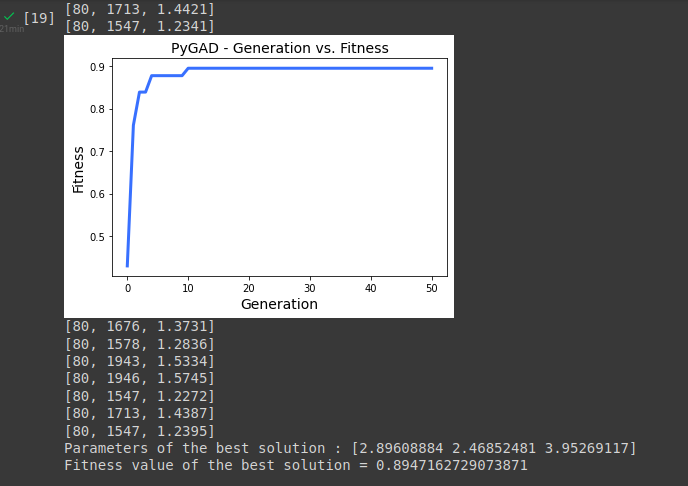

[96, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


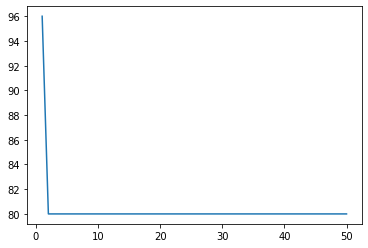

In [ ]:
print(levels)
print(gens)


matplotlib.pyplot.plot(gens,levels)

<h1> Print de resultado anterior </h1>


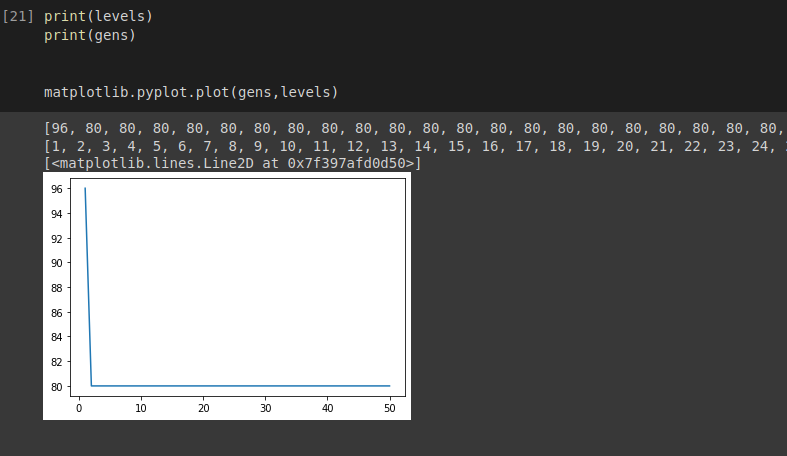

In [ ]:
max_iter = 100000
n = 4
w0 = 2.8
w1 = 2.4
w2 = 3.9
heuristic = [2.8, 2.4, 3.9]

init_state = "2 15 5 4 10 0 8 13 14 3 9 7 1 6 12 11"
goal_state = "1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0"

In [ ]:
init_state = init_state.split()
for i in range(len(init_state)):
    init_state[i] = int(init_state[i])

goal_state = goal_state.split()
for i in range(len(goal_state)):
    goal_state[i] = int(goal_state[i])

init_state = np.array(init_state).reshape(n, n)
goal_state = np.array(goal_state).reshape(n, n)

In [ ]:
A_star(init_state, goal_state, max_iter, heuristic)


INITIAL STATE
[ 2 15  5  4]
[10  0  8 13]
[14  3  9  7]
[ 1  6 12 11]

Moved DOWN  from (1, 1) --> (2, 1)
Score using w0 = 2.8 w1 = 2.4 w2 = 3.9 heuristic is 240.42846043299502 in level 1
[ 2 15  5  4]
[10  3  8 13]
[14  0  9  7]
[ 1  6 12 11]

Moved RIGHT from (2, 1) --> (2, 2)
Score using w0 = 2.8 w1 = 2.4 w2 = 3.9 heuristic is 228.5232282140009 in level 2
[ 2 15  5  4]
[10  3  8 13]
[14  9  0  7]
[ 1  6 12 11]

Moved RIGHT from (2, 2) --> (2, 3)
Score using w0 = 2.8 w1 = 2.4 w2 = 3.9 heuristic is 220.49236242749078 in level 3
[ 2 15  5  4]
[10  3  8 13]
[14  9  7  0]
[ 1  6 12 11]

Moved UP    from (2, 3) --> (1, 3)
Score using w0 = 2.8 w1 = 2.4 w2 = 3.9 heuristic is 222.6635953278379 in level 4
[ 2 15  5  4]
[10  3  8  0]
[14  9  7 13]
[ 1  6 12 11]

Moved LEFT  from (1, 3) --> (1, 2)
Score using w0 = 2.8 w1 = 2.4 w2 = 3.9 heuristic is 216.88426044008708 in level 5
[ 2 15  5  4]
[10  3  0  8]
[14  9  7 13]
[ 1  6 12 11]

Moved DOWN  from (1, 2) --> (2, 2)
Score using w0 = 2.8 w1 =

<h1> Print de resultado anterior </h1>


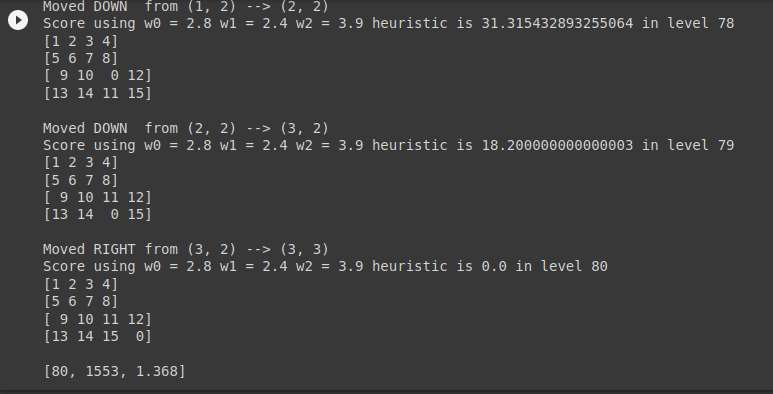

<h1> Análise e discussão dos resultados </h1>

<p> Após aplicarmos o EHA*, conseguimos os melhores pesos para o A* e com isso, obtivemos uma melhora considerável no desempenho do mesmo.
Na primeira execução, encontramos um número maior de níveis, de nós visitados e do tempo para a solução em comparação com a segunda execução que foi vista acima.
<p>







Para fins de comparação de desempenho entre as duas abordagens, realizamos um experimento analisando: quantidade de movimentos, quantidade de nós visitados (pelo algoritmo) e tempo gasto para alcançar o estado final desejado.

A metodologia se deu da seguinte forma:

*   5 estados iniciais foram gerados de forma aleatória no modelo 4x4.

*   Os estados foram repassados para os dois métodos. No caso do A*, os pesos destinados para cada heurística foram escolhidos de forma aleatória.

*   Foi feita a média de cada variável de interesse entre os 5 resultados de cada método.

Na tabela a seguir encontra-se o resultado comparativo, onde o método EHA* apresentou uma melhora nas três variáveis analisadas.

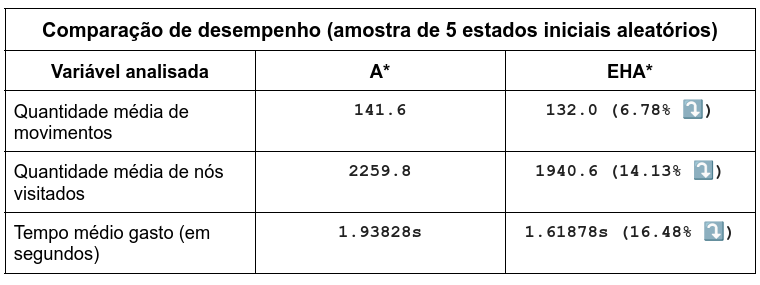